In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from datetime import datetime
%matplotlib inline

In [178]:
df = pd.read_csv('data/source_ready.csv', encoding='utf-8')
df.head(2)

,FOLIO,TIPO,LUGAR,FECHA,SALIDA,LLEGADA,CAUSA,COLONIA,ESTACION
0,01012016-0007-INZB-2A,INCENDIO DE ZACATE Y BASURA,COMERCIO,2016-01-01T00:00:00Z,2016-01-01T00:07:00Z,2016-01-01T00:16:00Z,FUEGO DIRECTO,SIN COLONIA,2
1,01012016-0022-INZB-1A,INCENDIO DE ZACATE Y BASURA,CASA,2016-01-01T00:00:00Z,2016-01-01T00:22:00Z,2016-01-01T00:32:00Z,FUEGO DIRECTO,LOMAS DE MADRID,1


In [179]:
df_llegada_valida = df[(pd.to_datetime(df['LLEGADA']) > pd.to_datetime(df['SALIDA'])) & (df['LLEGADA'].isna()!=True)].copy()

temp = pd.to_datetime(df_llegada_valida['LLEGADA']) - pd.to_datetime(df_llegada_valida['SALIDA'])

df_llegada_valida['TIEMPO TRANSCURRIDO'] = temp.apply(lambda x: x.to_timedelta64().astype('timedelta64[m]').astype('int'))

df_llegada_valida.drop(['FOLIO', 'FECHA','SALIDA','LLEGADA'], axis=1, inplace=True)

df_llegada_valida = df_llegada_valida[(df_llegada_valida['TIEMPO TRANSCURRIDO']>0) & (df_llegada_valida['TIEMPO TRANSCURRIDO']< 120)].copy()

df_llegada_valida.head(2)

,TIPO,LUGAR,CAUSA,COLONIA,ESTACION,TIEMPO TRANSCURRIDO
0,INCENDIO DE ZACATE Y BASURA,COMERCIO,FUEGO DIRECTO,SIN COLONIA,2,9
1,INCENDIO DE ZACATE Y BASURA,CASA,FUEGO DIRECTO,LOMAS DE MADRID,1,10


In [180]:
df_categorias = df_llegada_valida.copy()

le_tipo = LabelEncoder()
le_lugar = LabelEncoder()
le_causa = LabelEncoder()
le_colonia = LabelEncoder()

df_categorias['TIPO_LE'] = le_tipo.fit_transform(df_categorias['TIPO'])
df_categorias['LUGAR_LE'] = le_lugar.fit_transform(df_categorias['LUGAR'])
df_categorias['CAUSA_LE'] = le_causa.fit_transform(df_categorias['CAUSA'])
df_categorias['COLONIA_LE'] = le_colonia.fit_transform(df_categorias['COLONIA'])

df_categorias.head()

,TIPO,LUGAR,CAUSA,COLONIA,ESTACION,TIEMPO TRANSCURRIDO,TIPO_LE,LUGAR_LE,CAUSA_LE,COLONIA_LE
0,INCENDIO DE ZACATE Y BASURA,COMERCIO,FUEGO DIRECTO,SIN COLONIA,2,9,18,4,22,581
1,INCENDIO DE ZACATE Y BASURA,CASA,FUEGO DIRECTO,LOMAS DE MADRID,1,10,18,3,22,319
2,INCENDIO DE CASA DE MATERIAL,CASA,OTROS,PUERTA REAL RESIDENCIAL,1,14,13,3,38,489
3,INCENDIO DE ZACATE Y BASURA,VEHICULO,FUEGO DIRECTO,NORBERTO ORTEGA,2,4,18,10,22,374
4,INCENDIO DE ZACATE Y BASURA,CASA,FUEGO DIRECTO,MIGUEL HIDALGO,2,8,18,3,22,355


In [181]:
df_numerica = df_categorias.drop(['TIPO','LUGAR','CAUSA', 'COLONIA'], axis=1).copy()
df_numerica.head(2)

,ESTACION,TIEMPO TRANSCURRIDO,TIPO_LE,LUGAR_LE,CAUSA_LE,COLONIA_LE
0,2,9,18,4,22,581
1,1,10,18,3,22,319


In [182]:
df_numerica['MES'] = pd.to_datetime(df['FECHA']).apply(lambda x: int(x.strftime('%m')))
df_numerica['AÑO'] = pd.to_datetime(df['FECHA']).apply(lambda x: int(x.strftime('%Y')))
df_numerica['DIA_SEMANA'] = pd.to_datetime(df['FECHA']).apply(lambda x: x.weekday())

df_numerica.head()

,ESTACION,TIEMPO TRANSCURRIDO,TIPO_LE,LUGAR_LE,CAUSA_LE,COLONIA_LE,MES,AÑO,DIA_SEMANA
0,2,9,18,4,22,581,1,2016,4
1,1,10,18,3,22,319,1,2016,4
2,1,14,13,3,38,489,1,2016,4
3,2,4,18,10,22,374,1,2016,4
4,2,8,18,3,22,355,1,2016,4


In [183]:
X = df_numerica.drop('TIPO_LE', axis='columns')
y = df_numerica['TIPO_LE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

model = RandomForestClassifier(n_estimators=1000)
model.fit(X_train, y_train)
model.score(X_test,y_test)

0.758121940364931

In [184]:
y_predicted = model.predict(X_test)
cm = confusion_matrix(y_test, y_predicted)
x, y = cm.shape

In [185]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.46      0.46      0.46       112
           1       0.31      0.26      0.28       189
           2       0.00      0.00      0.00        13
           3       0.18      0.10      0.13        20
           5       0.44      0.42      0.43        84
           6       0.00      0.00      0.00         2
           7       0.90      0.96      0.92       678
           8       0.00      0.00      0.00         6
           9       0.69      0.60      0.64       257
          10       0.67      0.85      0.75       256
          11       1.00      0.12      0.22         8
          12       0.54      0.23      0.33        81
          13       0.54      0.58      0.56       374
          14       0.55      0.39      0.46        59
          15       0.00      0.00      0.00         9
          16       0.33      0.04      0.07        24
          17       0.76      0.84      0.79       217
          18       0.87    

/home/diademuertos/scripts/Python3/Jupiter/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[Text(159.0, 0.5, 'Truth'), Text(0.5, 114.0, 'Predicted')]

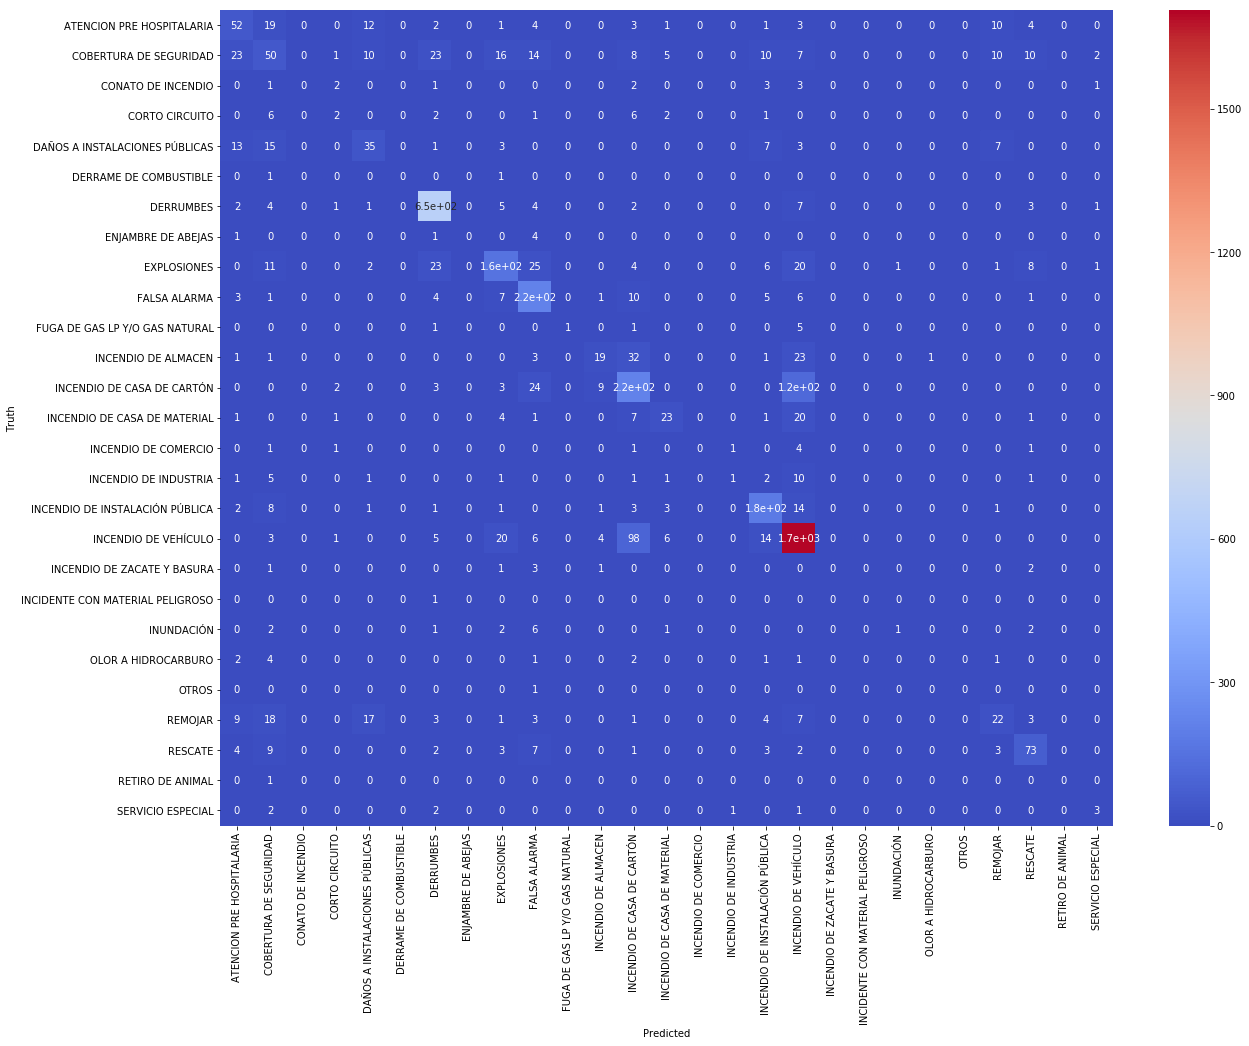

In [186]:
plt.figure(figsize=(20,15))
ax = sns.heatmap(pd.DataFrame(cm, columns=le_tipo.classes_[:x], index=le_tipo.classes_[:x]), annot=True, cmap="coolwarm")
ax.set(xlabel='Predicted', ylabel='Truth')